In [1]:
%matplotlib inline
import os
import time
import numpy
import pandas as pd
import matplotlib

In [2]:
# Example of coupled execution
# log_files = {'new': 'slurm-4240.out'}

# Example of completed uncoupled, with bad node?
log_files = {'new': 'slurm-4457.out'}

# Example of completed uncoupled, without bad node?
log_files = {'new': 'slurm-4459.out'}

log_files = {'new': 'slurm-4740.out'}

# log_files = {'new': 'slurm-4236.out'}
# log_files = {1: 'slurm-3600.out', 4: 'slurm-3601.out', 16: 'slurm-3602.out', 'rwlock': 'slurm-4235.out'}

In [3]:
 def log_file_to_dataframe(log_file):
    fp = open(log_file, 'r')
    perf_records = []
    for line in fp:
        if line.startswith('PE ') and line.find('- total') != -1:
            tokens = line.split()

            # Sample line in log file:
            #   PE 6 - total 1336.802000 ms - metadata 54.481000 ms (50.733000 0.000000) - \
            #     summary 3.805000 ms (1.763000 0.072000 1.970000 | 0.065000 0.037000 0.048000 1.820000) - \
            #     edges 1278.047000 ms (1190.644000 80.641000) - neighbor updates 0.411000 ms - \
            #     abort 0.058000 ms - 0 spins - 9 / 16 PE neighbors  - partition window = , 1522 / 28900 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=6688 misses=3553 age misses=0, feature cache hits=0 misses=0
            #
            # Sample new line in log file:
            #   PE 11 - total 42.046000 ms - metadata 26.715000 ms (26.212000 0.000000) - \
            #     summary 4.765000 ms (0.133000 0.023000 4.609000 | 1.428000 1.406000 1.281000 0.481000) - \
            #     edges 10.411000 ms (2.730000 7.445000) - neighbor updates 0.111000 ms - coupling 0.020000 ms - \
            #     throttling 0.024000 ms - 0 spins - 6 / 256 PE neighbors  - partition window = , 43 / 10000 active - \
            #     aborting? 0 - last step? 0 - remote cache hits=1611 misses=375 age misses=0, feature cache hits=0 misses=0
            index = 1
            pe = int(tokens[index])
            index += 3
            
            timestep = int(tokens[index])
            index += 3
            
            total = float(tokens[index])
            index += 4
            
            metadata = float(tokens[index])
            index += 6
            
            summary = float(tokens[index])
            index += 2
            summary_actor_partitions = float(tokens[index][1:])
            index += 1
            summary_time_window = float(tokens[index])
            index += 1
            summary_update_neighbors = float(tokens[index])
            index += 2
            summary_update_neighbors_lock = float(tokens[index])
            index += 1
            summary_update_neighbors_getmem = float(tokens[index])
            index += 1
            summary_update_neighbors_unlock = float(tokens[index])
            index += 1
            summary_update_neighbors_body = float(tokens[index][:len(tokens[index]) - 1])
            index += 3
            
            edges = float(tokens[index])
            index += 2
            edges_updates = float(tokens[index][1:])
            index += 1
            edges_getmem = float(tokens[index][:-1])
            index += 4
            
            neighbor_updates = float(tokens[index])
            index  += 5
            
            coupled_values = float(tokens[index])
            index += 4
            
            coupling = float(tokens[index])
            index += 2
            
            n_coupled_spins_str = tokens[index]
            n_coupled_spins_str = n_coupled_spins_str[1:]
            n_coupled_spins_str = n_coupled_spins_str[:len(n_coupled_spins_str) - 1]
            n_coupled_spins = int(n_coupled_spins_str)
            index += 3
            
            throttling = float(tokens[index])
            index += 3
            
            spins = int(tokens[index])
            index += 3
            
            n_neighbors = int(tokens[index])
            index += 10
            
            active_partitions = int(tokens[index])
            index += 14
            
            cache_hits_str = tokens[index]
            cache_hits = int(cache_hits_str.split('=')[1])
            index += 1
            
            cache_misses_str = tokens[index]
            cache_misses = int(cache_misses_str.split('=')[1])
            index += 2
            
            cache_age_misses_str = tokens[index]
            cache_age_misses_str = cache_age_misses_str.split('=')[1]
            cache_age_misses_str = cache_age_misses_str[:-1]
            cache_age_misses = int(cache_age_misses_str)

            perf_records.append({'pe': pe,
                                 'timestep': timestep,
                                 'total': total,
                                 'metadata': metadata,
                                 'summary': summary,
                                 'summary_actor_partitions': summary_actor_partitions,
                                 'summary_time_window': summary_time_window,
                                 'summary_update_neighbors': summary_update_neighbors,
                                 'summary_update_neighbors_lock': summary_update_neighbors_lock,
                                 'summary_update_neighbors_getmem': summary_update_neighbors_getmem,
                                 'summary_update_neighbors_unlock': summary_update_neighbors_unlock,
                                 'summary_update_neighbors_body': summary_update_neighbors_body,
                                 'edges': edges,
                                 'edges_updates': edges_updates,
                                 'edges_getmem': edges_getmem,
                                 'neighbor_updates': neighbor_updates,
                                 'coupling': coupling,
                                 'n_coupled_spins': n_coupled_spins,
                                 'coupled_values': coupled_values,
                                 'throttling': throttling,
                                 'spins': spins,
                                 'n_neighbors': n_neighbors,
                                 'active_partitions': active_partitions,
                                 'cache_hits': cache_hits,
                                 'cache_misses': cache_misses,
                                 'cache_age_misses': cache_age_misses})
    fp.close()
    return pd.DataFrame(perf_records)

In [4]:
dfs = {}
for nnodes in log_files:
    dfs[nnodes] = log_file_to_dataframe(log_files[nnodes])

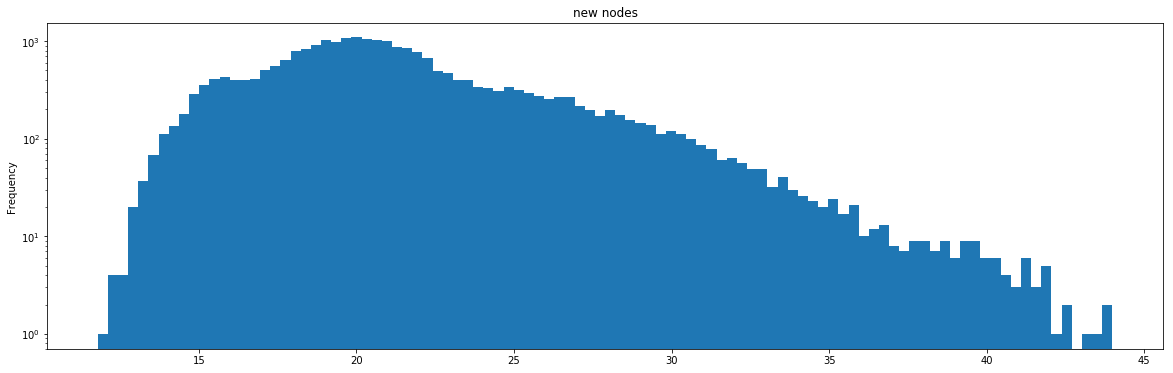

In [5]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['total'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes', logy = True)

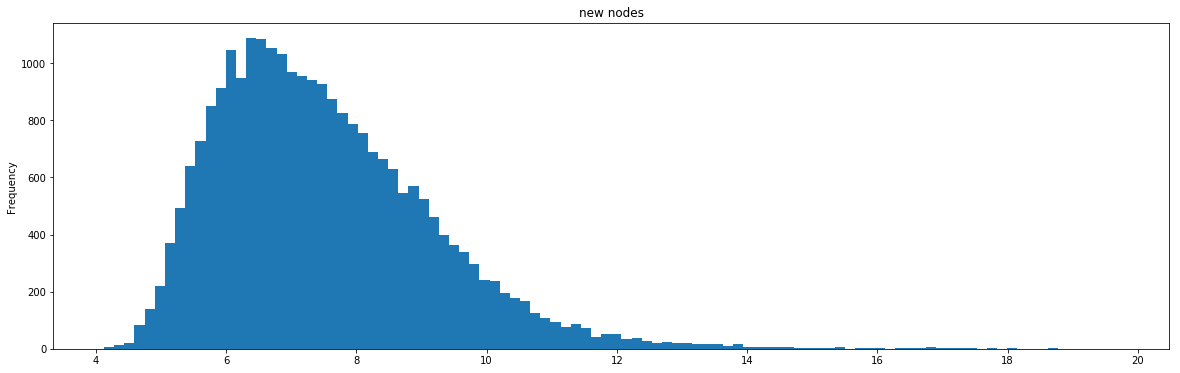

In [6]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['summary'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

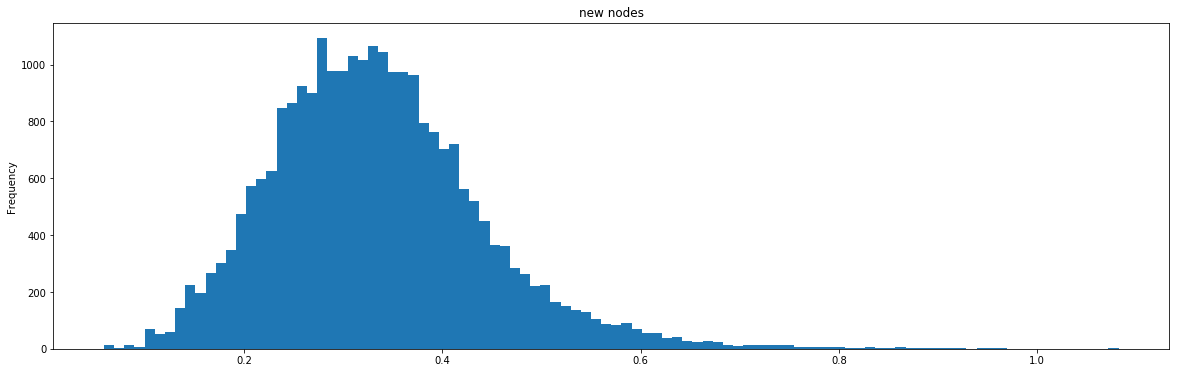

In [7]:
for nnodes in sorted(dfs.keys()):
    fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
    dfs[nnodes]['metadata'].plot(kind = 'hist', bins = 100, ax = ax, title = str(nnodes) + ' nodes')

In [8]:
dfs['new'].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

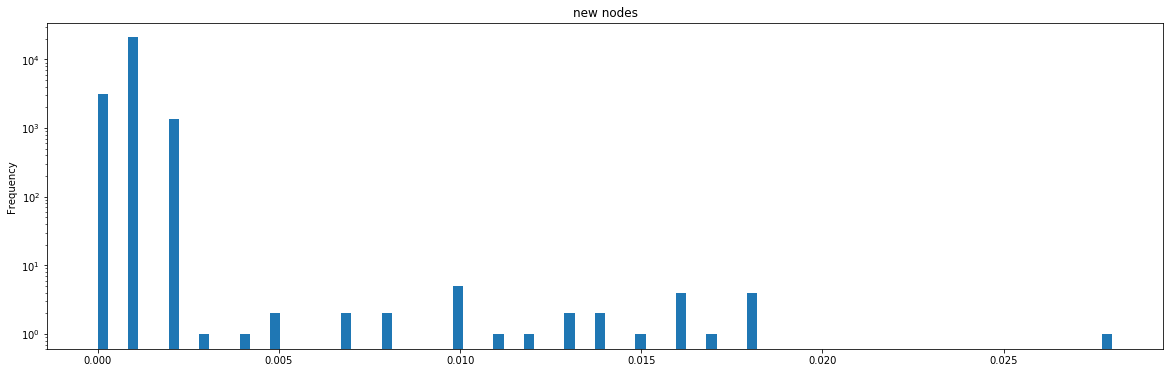

In [9]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

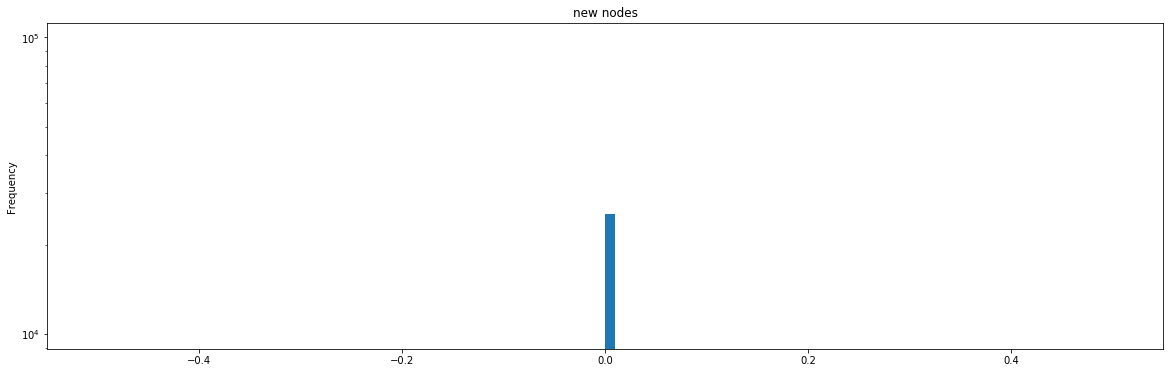

In [10]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['n_coupled_spins'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [11]:
dfs['new'].sort_values(by = 'coupling', ascending = False)

,active_partitions,cache_age_misses,cache_hits,cache_misses,coupled_values,coupling,edges,edges_getmem,edges_updates,metadata,...,summary_actor_partitions,summary_time_window,summary_update_neighbors,summary_update_neighbors_body,summary_update_neighbors_getmem,summary_update_neighbors_lock,summary_update_neighbors_unlock,throttling,timestep,total
17981,46,4609,25567,416,0.041,0.028,18.155,11.702,5.972,0.597,...,0.080,0.080,7.636,0.782,2.205,2.383,2.248,0.042,71,26.785
8894,46,2025,12774,428,0.019,0.018,10.679,8.046,2.296,0.284,...,0.025,0.023,10.456,0.522,3.359,3.341,3.220,0.034,35,21.617
7864,45,2083,10958,392,0.016,0.018,11.613,9.106,2.175,0.287,...,0.032,0.033,9.543,0.521,2.888,3.116,3.008,0.042,34,21.662
14704,47,4636,20437,432,0.038,0.018,13.111,10.416,2.366,0.287,...,0.029,0.052,8.874,0.542,2.919,2.872,2.527,0.083,60,22.578
8229,46,2383,10307,358,0.017,0.018,11.962,9.595,2.107,0.178,...,0.024,0.019,6.993,0.562,1.992,2.268,2.154,0.045,36,19.338
6288,47,1535,9062,409,0.034,0.017,10.249,7.706,2.146,0.475,...,0.041,0.044,7.255,0.518,2.144,2.532,2.047,0.069,26,18.261
9138,47,1965,12476,419,0.029,0.016,13.699,10.967,2.354,0.431,...,0.038,0.034,9.241,0.586,2.600,3.240,2.801,0.105,35,23.689
20498,47,4166,25085,417,0.019,0.016,14.870,8.704,5.653,0.394,...,0.036,0.027,11.422,0.833,3.344,3.808,3.419,0.042,72,26.897
3264,48,704,4639,432,0.022,0.016,17.422,14.726,2.373,0.443,...,0.029,0.049,10.432,0.539,3.120,3.515,3.245,0.057,13,28.559
10470,46,3091,13494,338,0.014,0.016,8.377,6.309,1.908,0.375,...,0.039,0.017,10.275,0.567,2.974,3.533,3.192,0.023,48,19.192


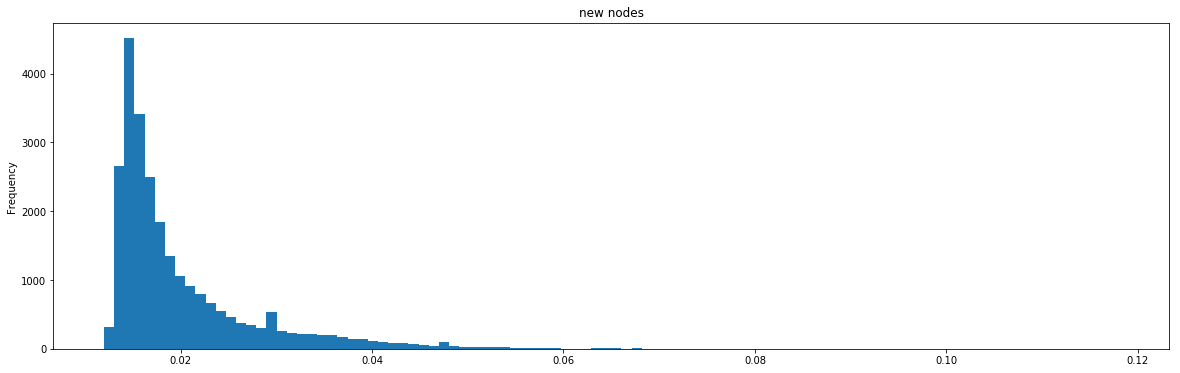

In [12]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['coupled_values'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

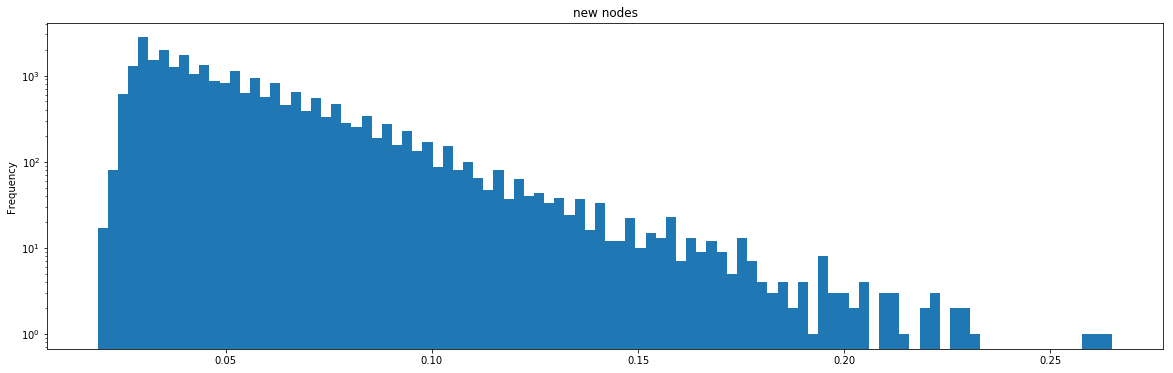

In [13]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['throttling'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes', logy = True)

In [14]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling')[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
0,0.019,0,2
25034,0.020,0,100
24956,0.021,0,98
15791,0.021,255,70
25101,0.021,167,92
25152,0.021,167,93
25175,0.021,167,94
619,0.021,0,10
11490,0.021,255,52
25232,0.021,167,96


In [15]:
# Who does the most throttling and least throttling?
dfs['new'].sort_values(by = 'throttling', ascending = False)[['throttling', 'pe', 'timestep']].head(10)

,throttling,pe,timestep
1351,0.265,211,7
13708,0.261,211,50
15997,0.260,201,66
8437,0.232,213,35
1561,0.230,137,7
2962,0.229,140,13
16010,0.227,203,65
16699,0.226,210,62
21651,0.223,213,88
11553,0.222,20,47


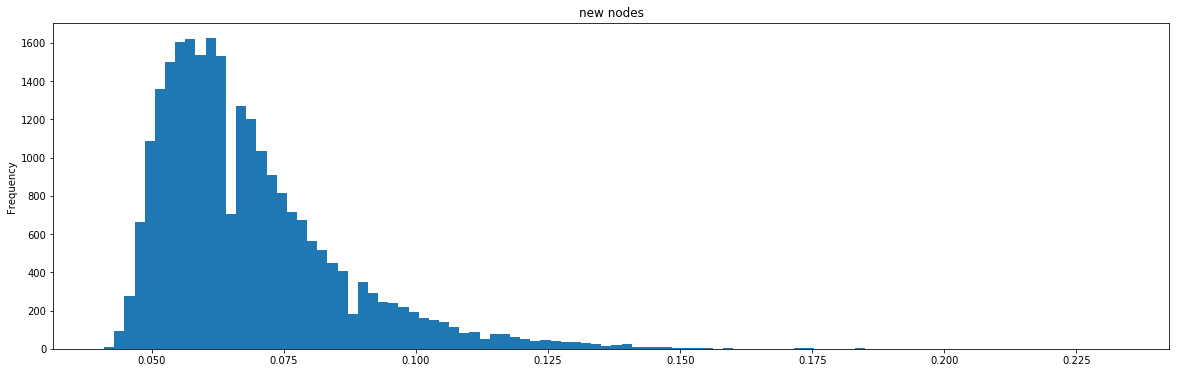

In [16]:
fig, ax = matplotlib.pyplot.subplots(figsize=(20.0, 6.0))
dfs['new']['neighbor_updates'].plot(kind = 'hist', bins = 100, ax = ax,
                            title = str(nnodes) + ' nodes')

In [17]:
dfs['new']['coupling'].min()

0.0

In [19]:
# 47, 48 do more throttling than 0, 255. However, they appear to only do this throttling
# very, very early in the simulation (around timestep 10) but when they do it, it is
# significant (>2 seconds).
interesting_pes = [0, 255, 47, 48]

df = dfs['new']
interesting_dfs = {}
for pe in interesting_pes:
    interesting_dfs[pe] = df[df['pe'].isin([pe])].sort_values(by = 'timestep')

In [20]:
interesting_dfs[interesting_pes[0]].columns

Index([u'active_partitions', u'cache_age_misses', u'cache_hits',
       u'cache_misses', u'coupled_values', u'coupling', u'edges',
       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
       u'summary_actor_partitions', u'summary_time_window',
       u'summary_update_neighbors', u'summary_update_neighbors_body',
       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
       u'total'],
      dtype='object')

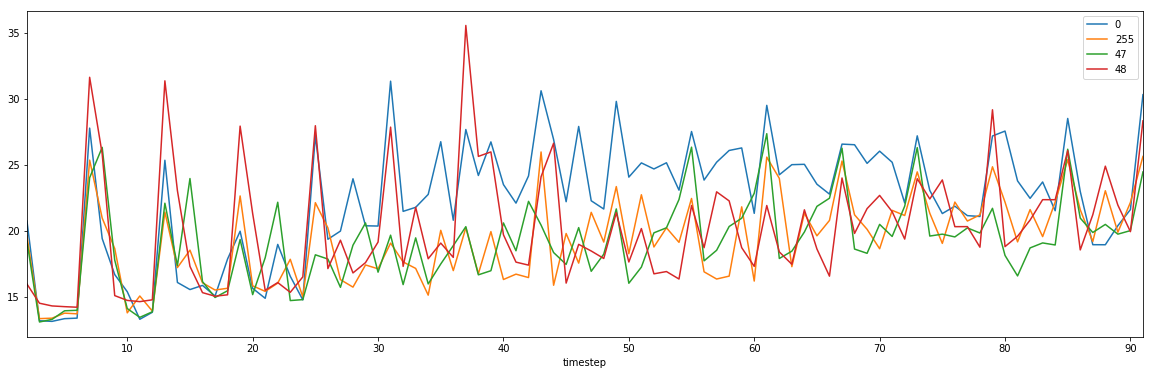

In [28]:
def plot_for_metric(metric):
    len_shortest_df = 90
    
    d = {'timestep': interesting_dfs[interesting_pes[0]]['timestep'].values[:len_shortest_df]}
    for pe in interesting_pes:
        d[str(pe)] = interesting_dfs[pe][metric].values[:len_shortest_df]
    
    pd.DataFrame(d).plot(kind = 'line', x = 'timestep', figsize = (20.0, 6.0))

plot_for_metric('total')

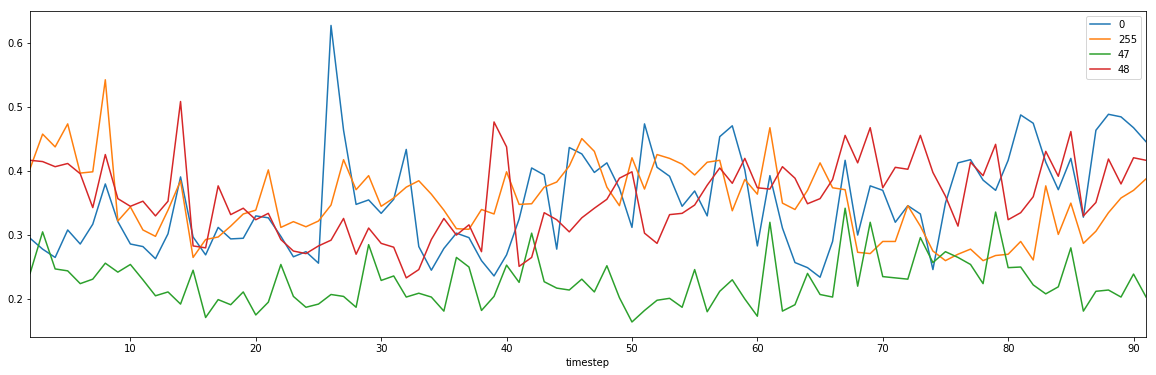

In [29]:
plot_for_metric('metadata')

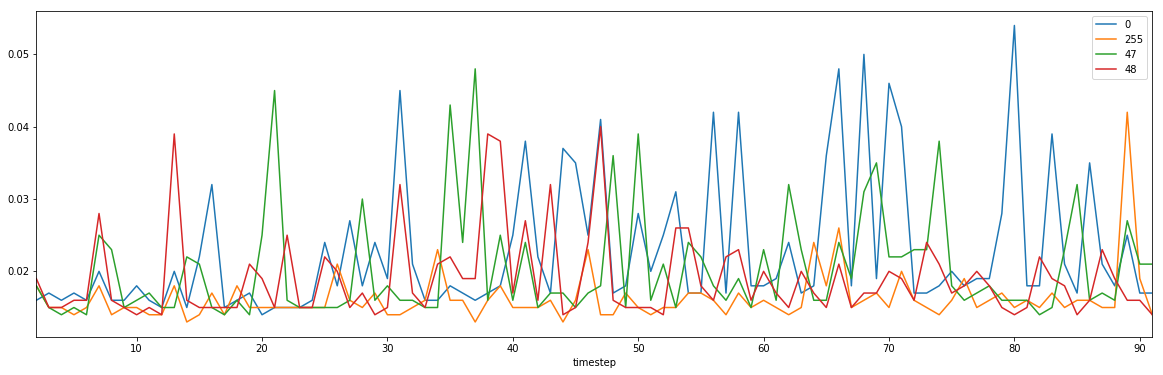

In [30]:
# 'coupled_values', 'coupling', 'edges', 'neighbor_updates', 'summary', 'throttling'
plot_for_metric('coupled_values')

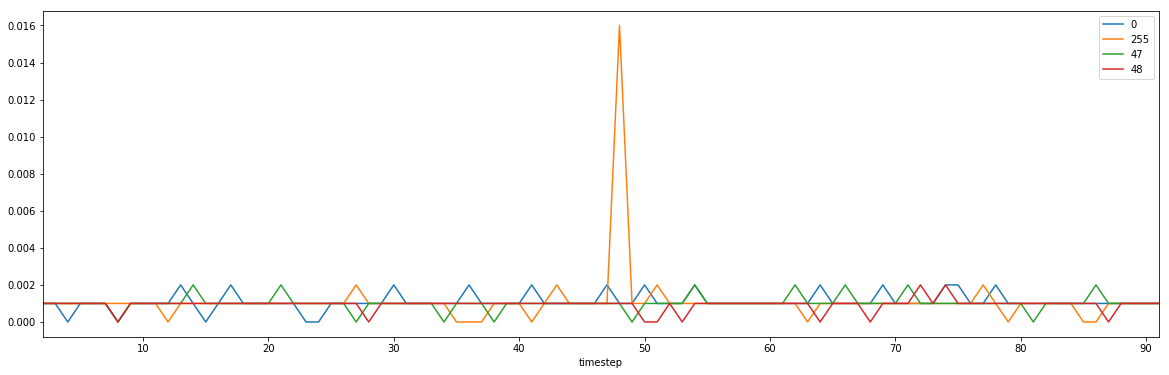

In [31]:
plot_for_metric('coupling')

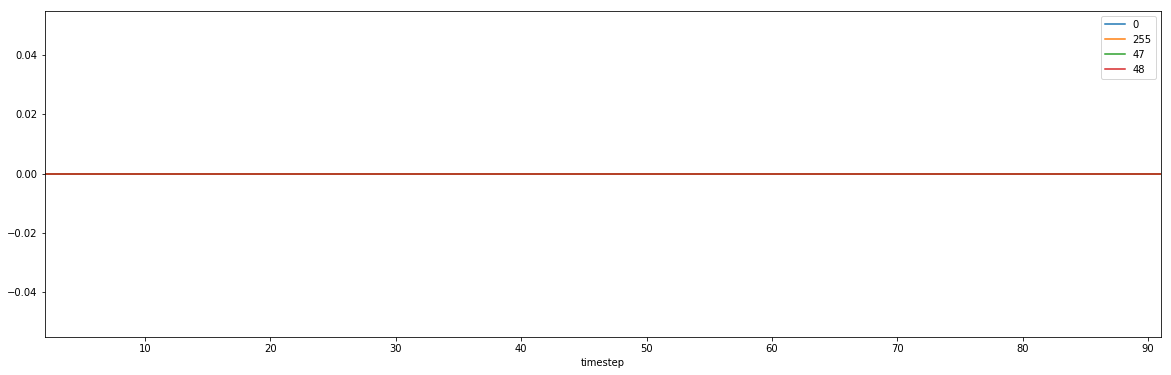

In [32]:
plot_for_metric('n_coupled_spins')

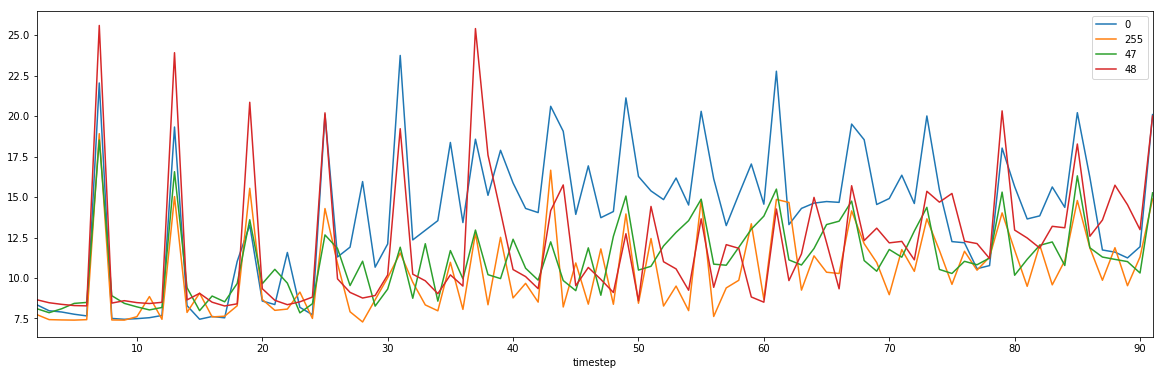

In [33]:
plot_for_metric('edges')

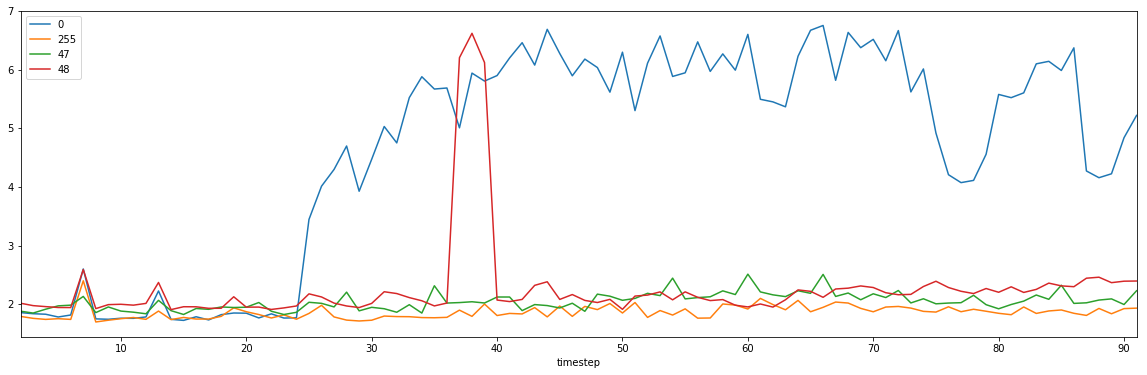

In [34]:
plot_for_metric('edges_updates')

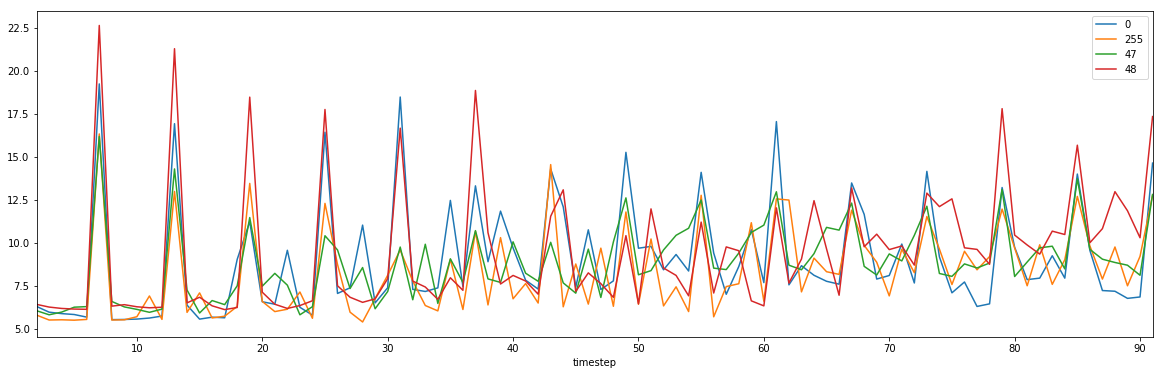

In [35]:
plot_for_metric('edges_getmem')

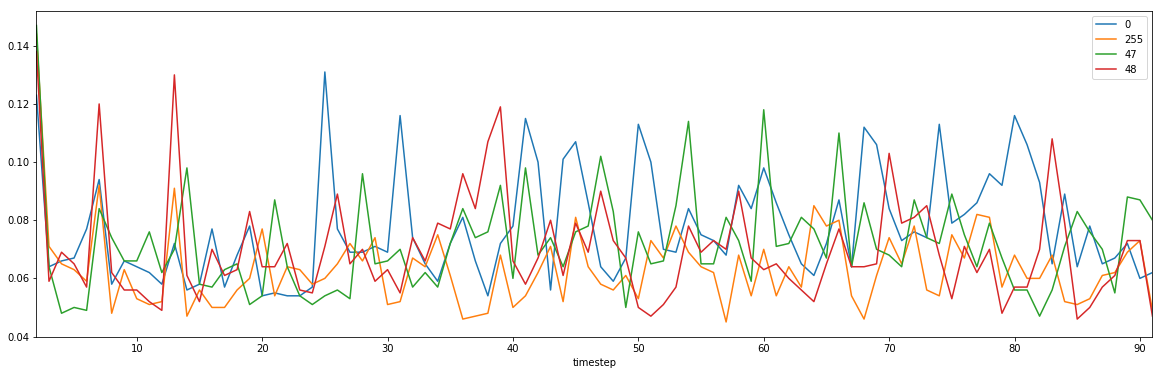

In [36]:
plot_for_metric('neighbor_updates')

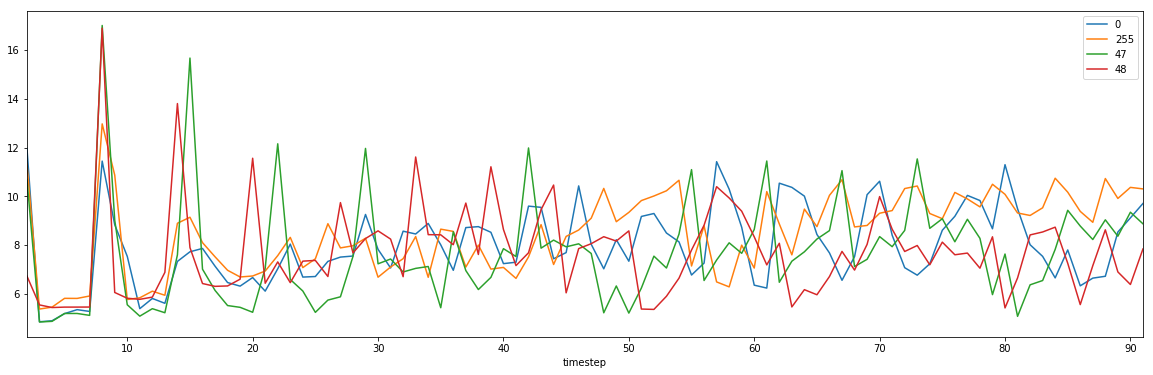

In [37]:
plot_for_metric('summary')

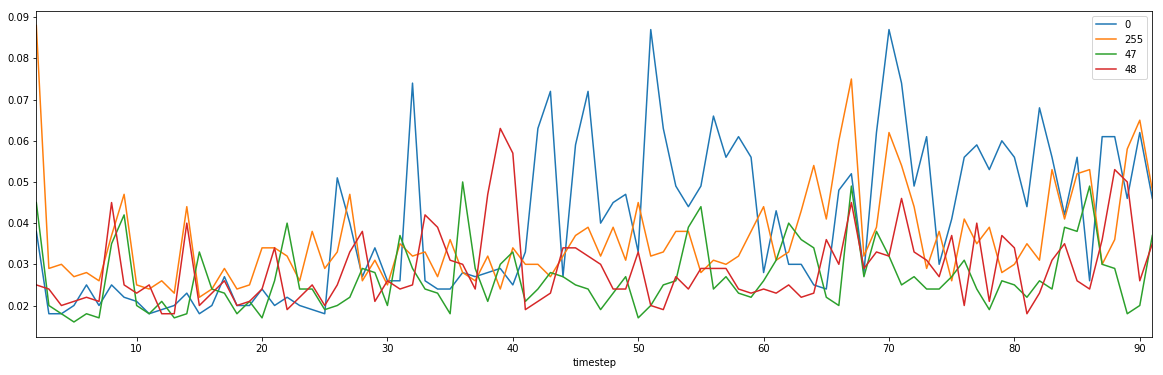

In [38]:
plot_for_metric('summary_actor_partitions')

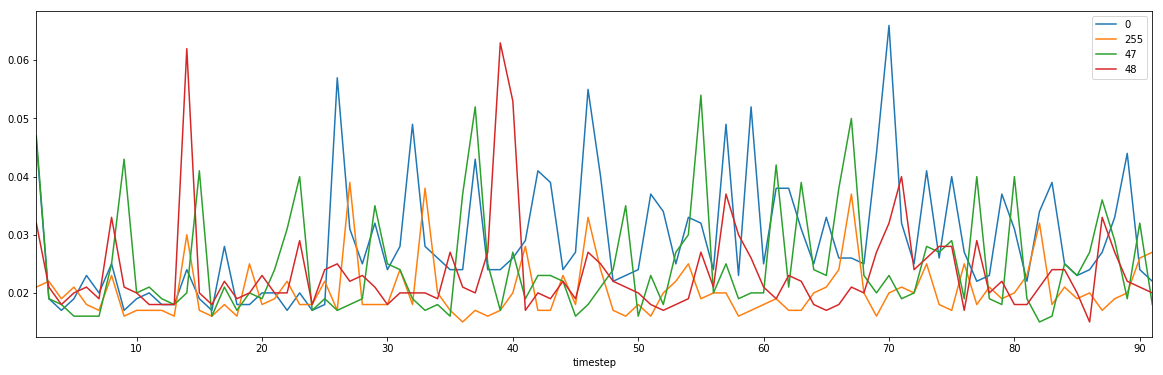

In [39]:
plot_for_metric('summary_time_window')

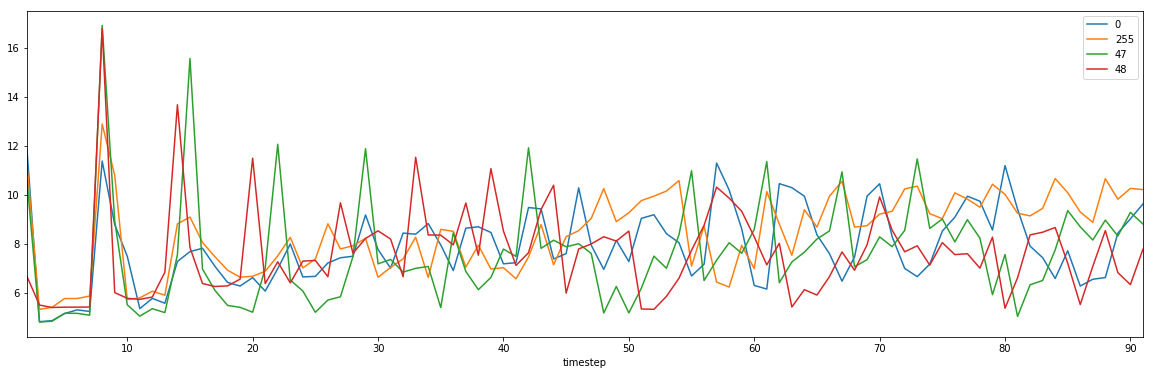

In [40]:
plot_for_metric('summary_update_neighbors')

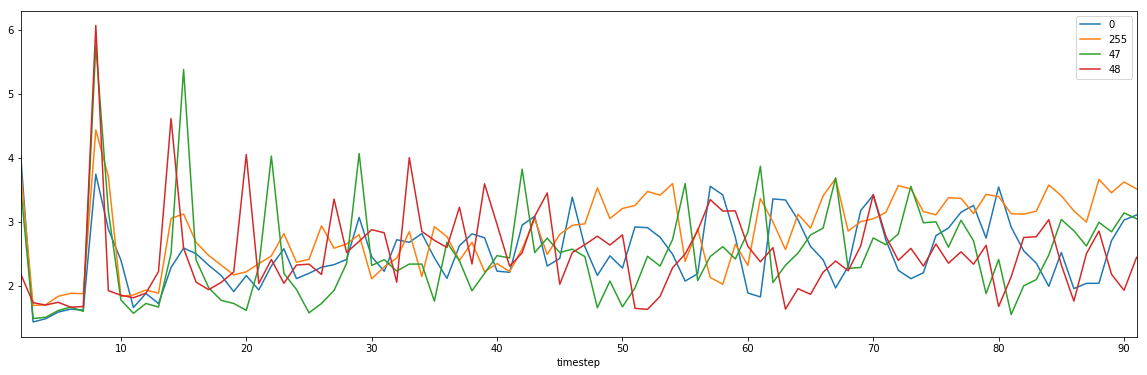

In [41]:
plot_for_metric('summary_update_neighbors_lock')

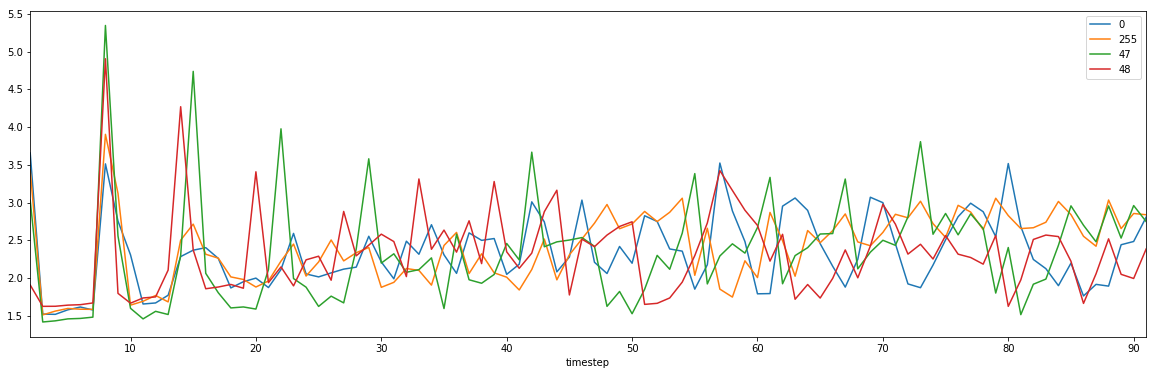

In [42]:
plot_for_metric('summary_update_neighbors_getmem')

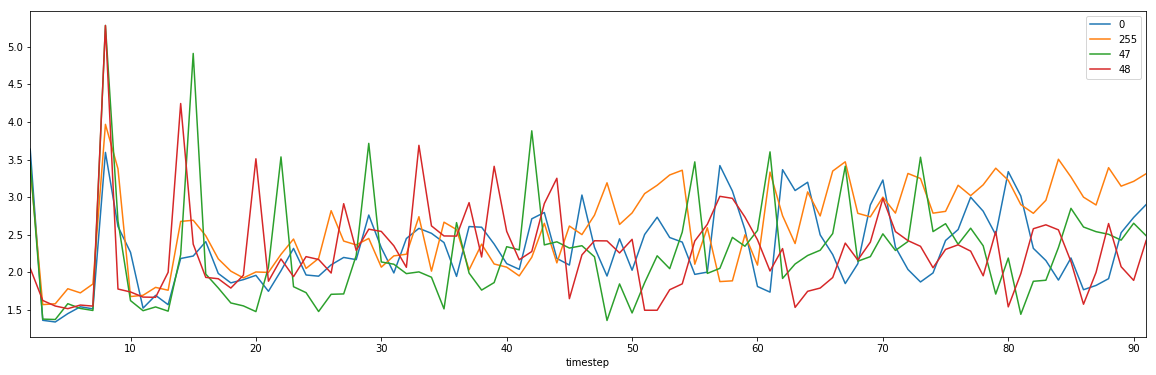

In [43]:
plot_for_metric('summary_update_neighbors_unlock')

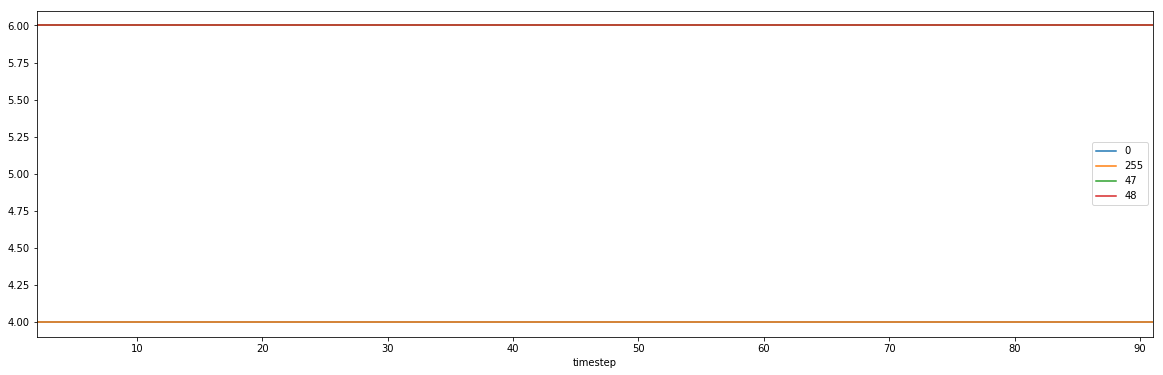

In [44]:
plot_for_metric('n_neighbors')

In [45]:
def compute_mean(metric):
    d = {}
    for pe in interesting_pes:
        d[pe] = interesting_dfs[pe][metric].mean()
    return d

compute_mean('n_neighbors')

{0: 4.0, 47: 6.0, 48: 6.0, 255: 4.0}

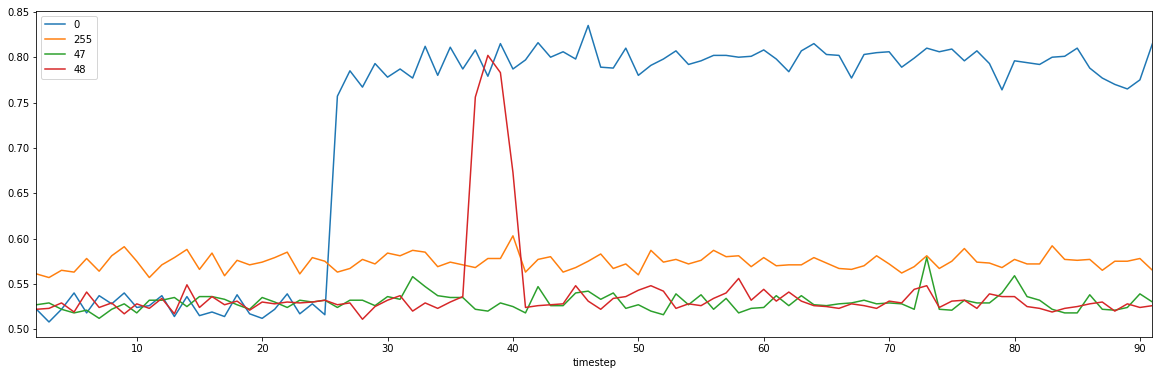

In [46]:
plot_for_metric('summary_update_neighbors_body')

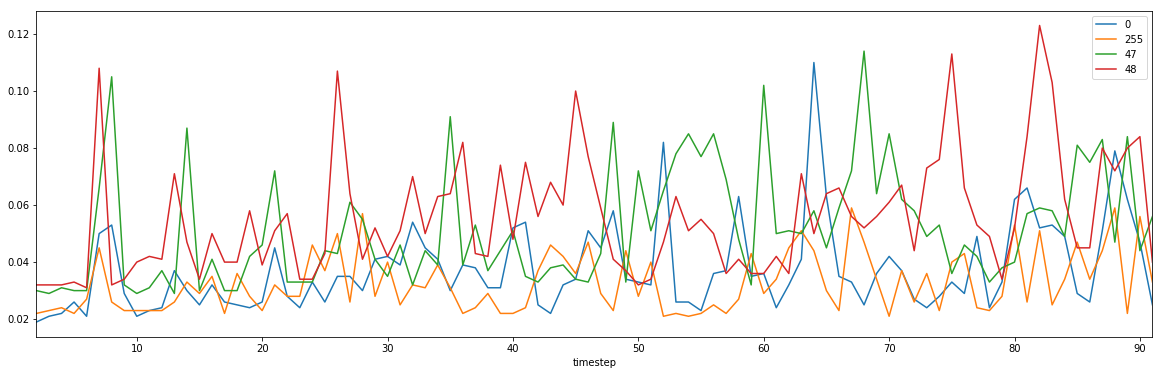

In [47]:
plot_for_metric('throttling')

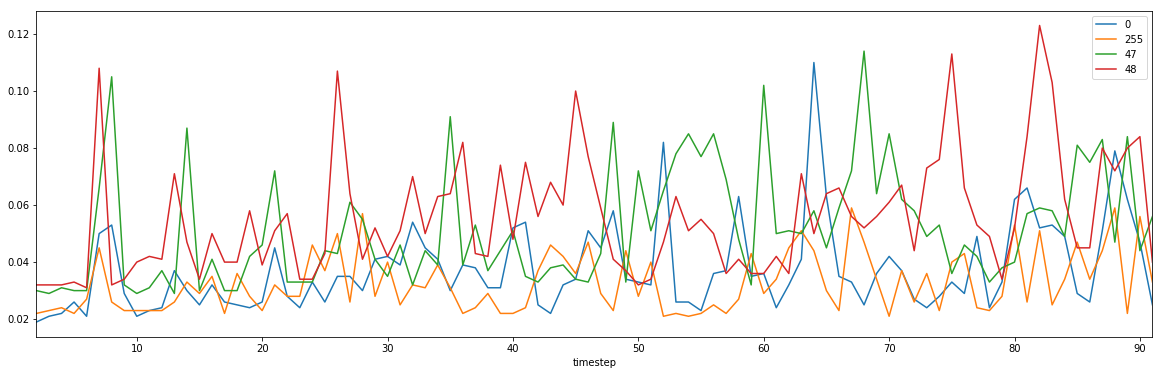

In [48]:
#[u'active_partitions', u'cache_age_misses', u'cache_hits',
#       u'cache_misses', u'coupled_values', u'coupling', u'edges',
#       u'edges_getmem', u'edges_updates', u'metadata', u'n_coupled_spins',
#       u'n_neighbors', u'neighbor_updates', u'pe', u'spins', u'summary',
#       u'summary_actor_partitions', u'summary_time_window',
#      u'summary_update_neighbors', u'summary_update_neighbors_body',
#       u'summary_update_neighbors_getmem', u'summary_update_neighbors_lock',
#       u'summary_update_neighbors_unlock', u'throttling', u'timestep',
#       u'total']
plot_for_metric('throttling')